# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.09KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


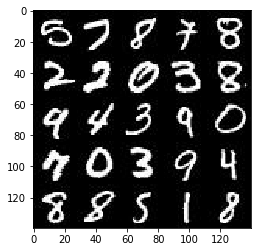

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

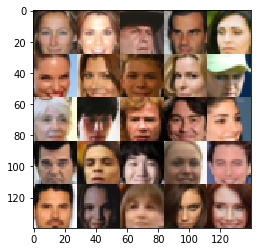

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    #mark_used()
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    keep_prob=0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())        
        relu1 = tf.maximum(alpha * c1, c1)
        relu1 = tf.layers.dropout(relu1, keep_prob, training=reuse)
        
        # 14X14x64
        
        c2 = tf.layers.conv2d(c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, keep_prob, training=reuse)

        # 7x7x128
        
        c3 = tf.layers.conv2d(c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())       
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, keep_prob, training=reuse)
        
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    rate=0.8
    with tf.variable_scope('generator', reuse=not is_train):
        # Project input vector
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.relu(x1)
        x1 = tf.layers.dropout(x1, rate, training=is_train)

        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.relu(x2)
        x2 = tf.layers.dropout(x2, rate, training=is_train)
        
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.relu(x3)
        x3 = tf.layers.dropout(x3, rate, training=is_train)
        
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='SAME',
                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_faked = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_faked, reuse=True)
    
    # Add smoothing to reduce labels
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=(tf.ones_like(d_model_fake))
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images), np.max(batch_images)))
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 12.7367
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 5.1377
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 3.2129
Epoch 1/2... Discriminator Loss: 0.4713... Generator Loss: 4.0583
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 3.6806
Epoch 1/2... Discriminator Loss: 2.6905... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 2.0450
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 3.1729
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 4.0039


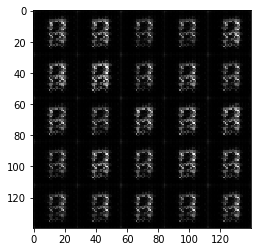

Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 4.0163
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 5.7139
Epoch 1/2... Discriminator Loss: 0.5488... Generator Loss: 3.4227
Epoch 1/2... Discriminator Loss: 0.5623... Generator Loss: 4.3701
Epoch 1/2... Discriminator Loss: 0.4062... Generator Loss: 4.2192
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 3.6419
Epoch 1/2... Discriminator Loss: 1.8106... Generator Loss: 5.6573
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 2.1830
Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 2.3372
Epoch 1/2... Discriminator Loss: 5.3856... Generator Loss: 8.6307


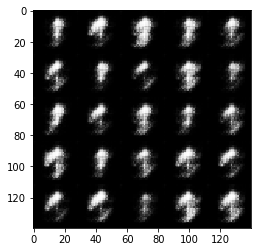

Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.7711
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 2.1020
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 2.9237
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 3.6955
Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 2.4859
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 2.3466
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 1.5366
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 2.6743
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 2.1846
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 1.5312


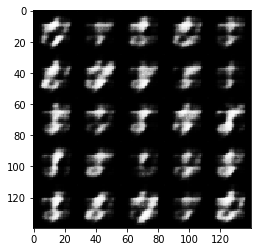

Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 1.9170
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 3.7267
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 2.9437
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 2.6918
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 2.9064
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 2.3770
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 1.4769
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 2.6698
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 1.7778


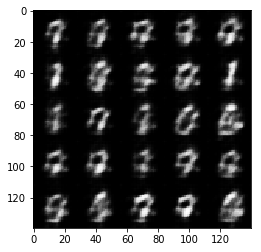

Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 1.3510
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 2.3366
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 1.8813
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.6690
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 1.6624
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 2.1550
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 1.4610


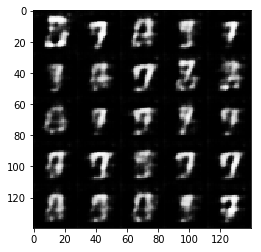

Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 1.9143
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.4660
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 1.5801
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 2.8491
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.4803
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.6938
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 2.0458
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 1.8700


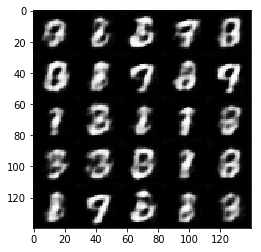

Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.9287
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 2.1001
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 2.0456
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.4914
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 2.0323
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 1.9598
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 1.5500
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.5439


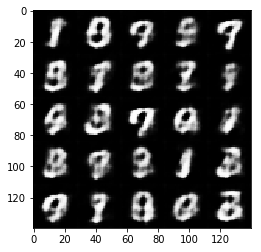

Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 2.1719
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.8044
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.7503
Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 1.7095
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.8463
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.9722
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 1.5031
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 2.3656
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 2.2526
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.4562


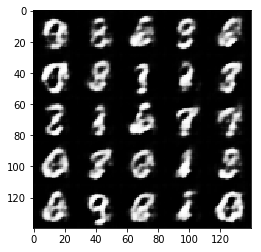

Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 2.2061
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.5920
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.5934
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.5829
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.3131
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 2.2333
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.3646
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 2.6620
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 1.5300


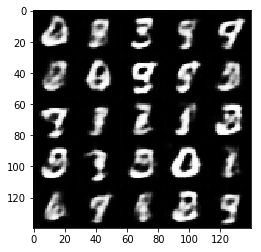

Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 1.4424
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.5533
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 1.8682
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 2.1432
Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 2.0647
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 2.1667
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 2.0700
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 1.2452
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 2.0239


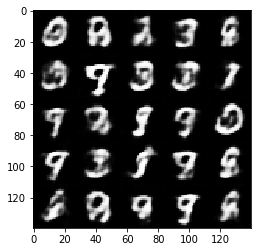

Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.9559
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 1.3385
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 2.0175
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 1.7709
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.7161
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 1.6041
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.7275
Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 2.0306


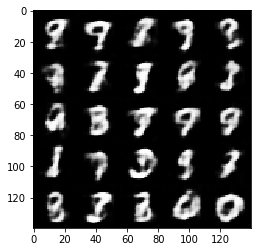

Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 2.5992
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 1.5379
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.6762
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.7990
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.5168
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 2.1495
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 2.1738
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.6572
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.9891
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 1.2806


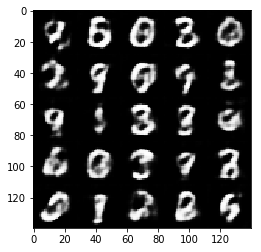

Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 1.1851
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 2.2923
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.3930
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 1.9564
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 2.1452
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 2.0414
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.5878
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.9956
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 2.0995
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 2.0788


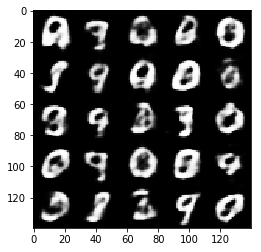

Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 2.7082
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 2.0717
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 1.7983
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 1.3225
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 1.8908
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 2.0803
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 1.9314
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.8414
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 2.0740


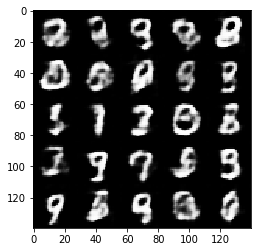

Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 1.9527
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 2.3055
Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 1.5163
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.7396
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 2.1666
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 2.0849
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 1.6227
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.5887
Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 2.4678
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 2.0603


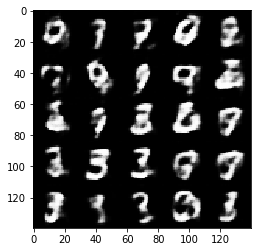

Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 2.3010
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.4008
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 1.6940
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 1.9954
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 2.1845
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 2.2246
Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 2.0499
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.7683


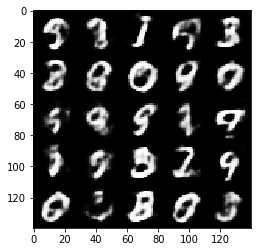

Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.8778
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 2.2088
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.7704
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.7580
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 2.0341
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 1.8385
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 1.8574
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 1.8250
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 1.6188
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 2.2564


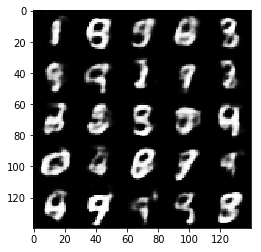

Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.6480
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 1.6934
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 2.5386
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 2.7648
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 1.9983
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 1.9939
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 1.9232
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 1.7660
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 1.6102
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.8013


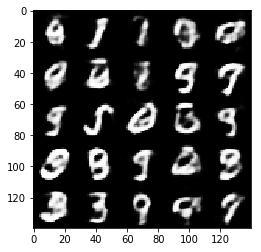

Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.6209
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 1.5848
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 1.8527
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.4850
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 1.5586
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.6507
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.8355
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 2.5144


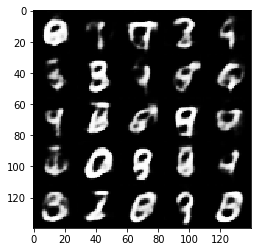

In [12]:
batch_size = 63
z_dim = 100
learning_rate = 0.001
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 2.0444
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.7154
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.2286
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 3.3879
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 2.8127
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.9211
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 3.3254
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 3.4573
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 3.4722


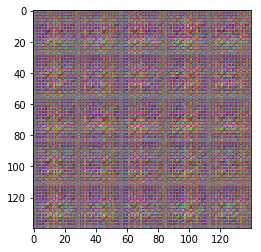

Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 4.1094
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 3.8737
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 4.1246
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 4.3054
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.9761
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 4.7207
Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 4.4551
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.6026
Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 4.3904
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 5.3591


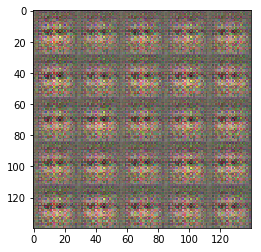

Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 4.5175
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 5.0735
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 4.6873
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 5.5601
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 4.6467
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 5.3305
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 5.3715
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 5.0339
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.1171
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 4.8976


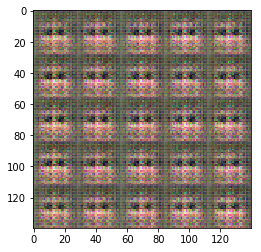

Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 5.6157
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 5.9953
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 5.2367
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 5.9987
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 5.5896
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.5152
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 5.4699
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 6.0478
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 6.5361
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 4.4504


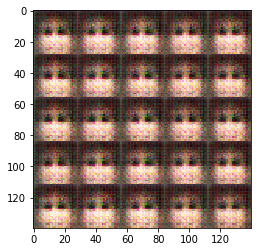

Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 5.5236
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 5.5753
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 5.8923
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 5.7520
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 6.5005
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 5.4562
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 6.0638
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 6.3036
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 5.4578
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 4.9404


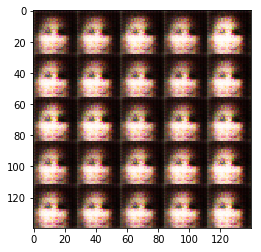

Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 4.9779
Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 6.3368
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 6.1649
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 5.3751
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 6.2481
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 6.7364
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 5.4767
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 5.6770
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 4.5300
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 5.1372


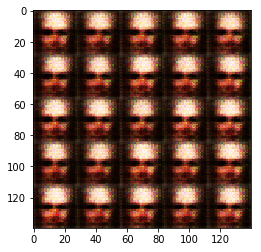

Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 6.0611
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 3.8047
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 4.8872
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 5.1442
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 6.3142
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 5.0813
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 5.3436
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 6.9067
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 6.4940
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 6.8544


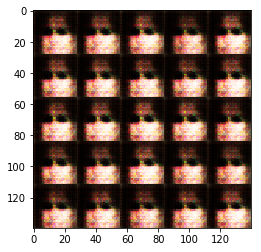

Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 5.6781
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 7.5935
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 6.7750
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 5.5012
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 3.8022
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 6.9497
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 4.7266
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 6.1436
Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 5.5552
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 5.3752


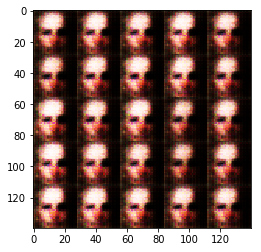

Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 5.1131
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 6.1757
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 5.0790
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 6.2897
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 6.1590
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 6.5622
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 4.2156
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 4.6728
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 6.7433
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.8443


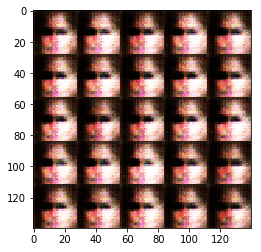

Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.6331
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 5.4839
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 4.5196
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 6.7028
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 4.3000
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 6.5957
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 5.8519
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 5.7913
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 5.7887
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 5.1354


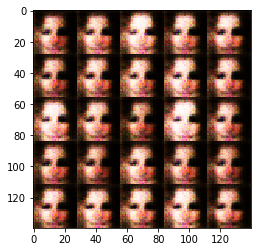

Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 5.8363
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 5.2404
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 5.1861
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 6.2939
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 4.9782
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 4.6405
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 5.1384
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 5.2168
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 5.4550
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 5.3921


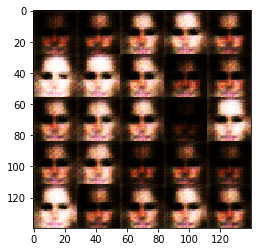

Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 4.9785
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 3.9554
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 6.2454
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 4.9219
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 4.7885
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 5.1313
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 5.5859
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 5.7159
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 6.0892
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 5.1623


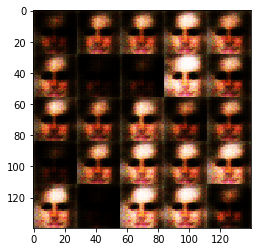

Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 4.7235
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 5.1655
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 6.5857
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 5.5173
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 6.3028
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 6.2198
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 4.5657
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 5.2552
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 6.3605
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 6.1608


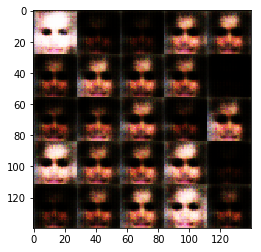

Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 5.3547
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 5.1485
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 6.1812
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 4.5324
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 5.5672
Epoch 1/1... Discriminator Loss: 0.3746... Generator Loss: 5.3804
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 4.5857
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 5.6548
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 4.4408
Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 5.8503


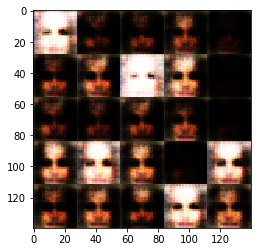

Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 4.8890
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 6.3434
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 5.8631
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 6.2125
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 5.4425
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 4.9757
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.8022
Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 5.4974
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 5.4976
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 4.8443


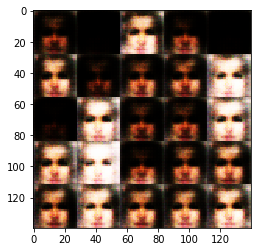

Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 5.0242
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 4.9269
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 5.4802
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 4.7163
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 6.0450
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 4.9033
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 5.3840
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 5.9731
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 5.4406
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 6.3634


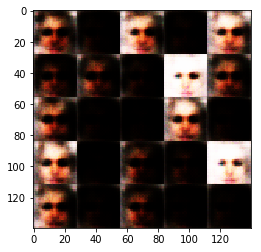

Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 5.2944
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 5.3736
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 4.8851
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 5.5598
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 5.1650
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 4.8353
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 6.4618
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 4.7821
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 5.2692
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 5.5957


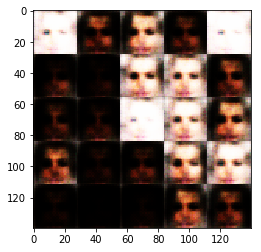

Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 6.4400
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 4.9635
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 6.0120
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 6.4142
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 5.0554
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 5.9838
Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 5.1367
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 6.0171
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 4.3557
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 6.8289


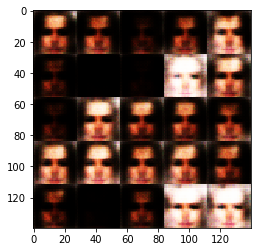

Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 5.1292
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 6.0605
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 6.1830
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 6.4741
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 5.3098
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 4.8957
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 4.9242
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.7830
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 5.6963
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 5.5391


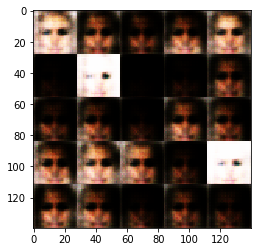

Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 5.1255
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 4.9940
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 5.8715
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 4.6581
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 4.8613
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 4.4299
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 5.4169
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 4.2923
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 6.6849
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 4.9266


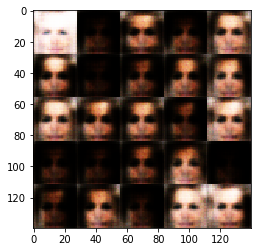

Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 4.7847
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 4.9727
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 5.0849
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 5.6868
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 6.5697
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 4.9981
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 4.2142
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 5.3517
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 6.0884
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 4.0606


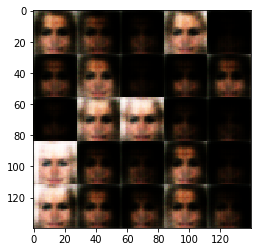

Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 4.8885
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 4.7131
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 4.6216
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 4.6303
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 5.1596
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 5.5990
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 3.4559
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 3.0809
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 5.5317
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 4.9031


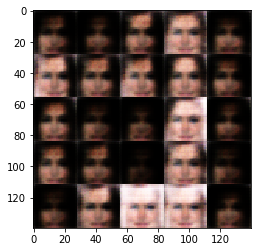

Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 4.1603
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 6.3849
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 4.3252
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.5841
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 4.3841
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 3.9845
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 3.9879
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 4.5696
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 3.1637
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.3617


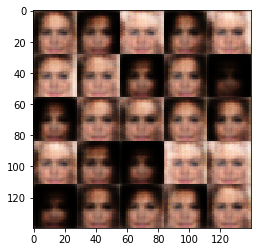

Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 3.9426
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.6874
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 4.3592
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.1726
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 3.3765
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 2.5673
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 4.0516
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.8849
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 4.5444
Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 3.9889


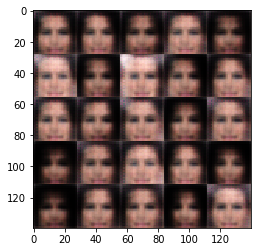

Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.1437
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 4.5847
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 4.9935
Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 4.6691
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 4.5780
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 3.9684
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.7988
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 4.0081
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 3.5076
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 4.5671


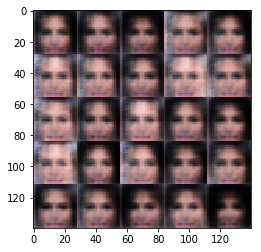

Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 5.1178
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 3.7249
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 3.4913
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 2.2893
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 4.8653
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.4679
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 4.0231
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 4.2245
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 3.5765
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 4.3259


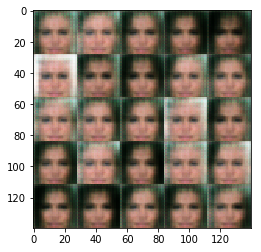

Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 4.2232
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 4.2094
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 3.8519
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 5.3674
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 4.3888
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 5.3498
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 6.0616
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 3.2317
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 5.5544
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 4.3577


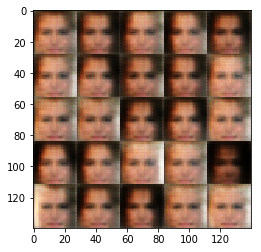

Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 3.7313
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.9101
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 4.5307
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 4.8989
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 4.0563
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 5.2693
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 4.3394
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 4.8689
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 4.1596
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 4.5667


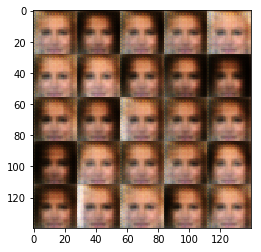

Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 4.8784
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 3.5760
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 4.1442
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 4.6496
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 4.8304
Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 4.8905
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 5.1891
Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 5.6891
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 4.5483
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 4.2450


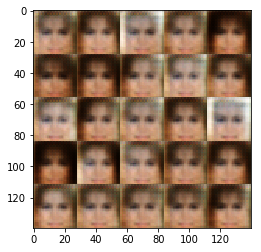

Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 4.1531
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 3.2798
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 5.1214
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 3.6996
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 4.5584
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 3.6159
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 3.1781
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 3.8781
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 4.4064
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 4.2781


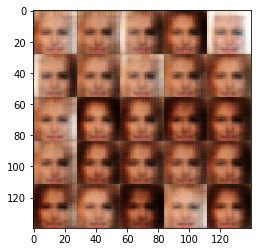

Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 5.4468
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 4.9891
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 2.0230
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 3.2791
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 4.0549
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 5.0918
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 4.4708
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 3.4911
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 3.9393
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 4.2557


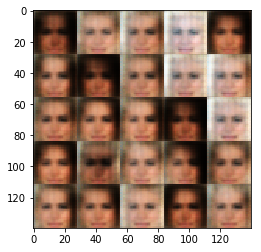

Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.7128
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 3.6065
Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 3.4078
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 4.5436
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 3.7699
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 3.8352
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 2.4095
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 2.2329
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 4.3958
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 3.4498


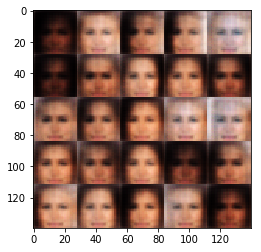

Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 4.9462
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 3.9792
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 4.2970
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 3.8002
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 3.0199
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 4.5028
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 3.3222
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 4.6377
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.9963
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 2.4716


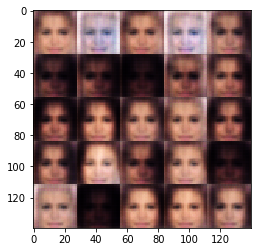

Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 3.0907
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 4.2644
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 4.9944
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.7114
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 3.6272
Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 3.8270
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 4.1428
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 5.0941
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 3.4382
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 3.8119


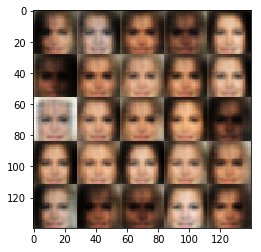

Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 2.7528
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 4.5080
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 4.9872
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 3.6160
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 2.8654
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 3.2221
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 3.2629
Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 3.6067
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 3.2682
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 3.7310


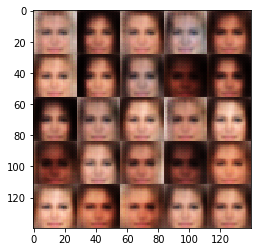

Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 2.9949
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 4.2361
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 3.9581
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 3.7211
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 3.9679
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 3.4290
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.3827
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.8581
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 4.1770
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 4.9185


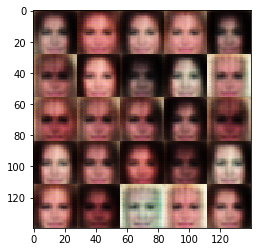

Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 4.4348
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 3.2171
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 3.5654
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 2.4761
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 2.9953
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 3.4141
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 3.1312
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.9298
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 4.1608
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 2.7381


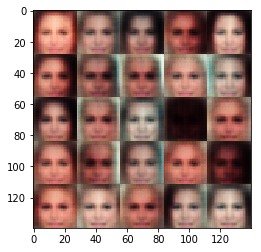

Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 3.4627
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 4.4383
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 3.7815
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 2.5180
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 2.4341
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 2.9013
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 3.0856
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 3.6813
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 3.4063
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 3.9361


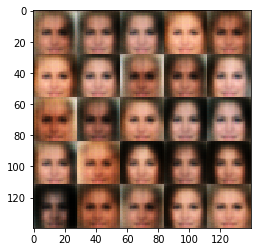

Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 3.3370
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 3.3506
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 3.4118
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.9140
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 3.8817
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 3.8695
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 3.8380
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 3.5256
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 4.8435
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 3.8812


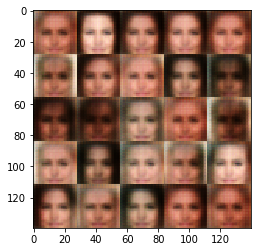

Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 4.1511
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.8304
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 4.0560
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 4.0517
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 4.0811
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 3.1155
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 4.0660
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 3.2064
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 4.1650
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 3.4874


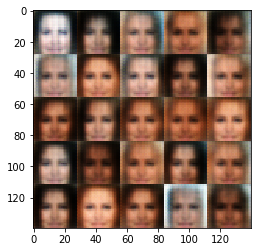

Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 4.3737
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 3.6126
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 3.1741
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 3.2168
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 2.7846
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 3.5089
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 3.3096
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 3.4737
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 3.9435
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 4.6017


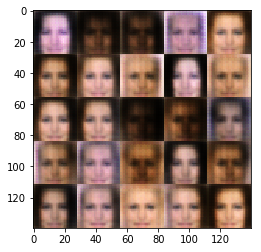

Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 3.5240
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 4.2532
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 4.0240
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.9615
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 3.3209
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 3.4143
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 4.1875
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 3.7543
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 5.4545
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 3.9095


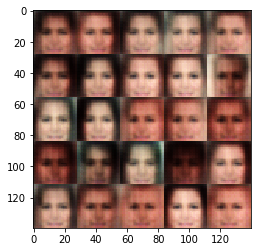

Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 3.7313
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 3.1188
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 2.7969
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 2.4884
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 3.6781
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 2.9663
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 4.0934
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 3.9032
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 3.7716
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 3.4681


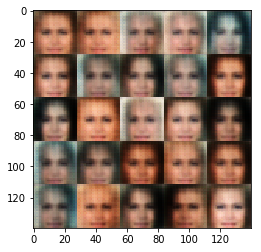

Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 3.2380
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 2.6033
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 3.7145
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.9884
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 3.8372
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 3.3177
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 4.2916
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 3.9456
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 4.4147
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 3.8641


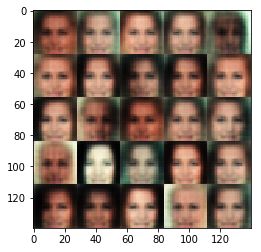

Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 4.7492
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 4.0278
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 3.1996
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 3.2226
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 2.1942
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 3.4084
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 3.5282
Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 3.4050
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 3.7493
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.5179


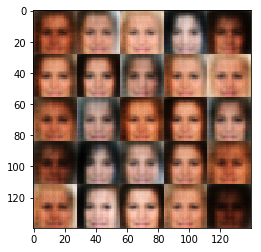

Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 4.3501
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 2.7756
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 2.9475
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 4.4355
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 4.4651
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 3.6232
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 4.9429
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.4259
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 3.4825
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 3.5065


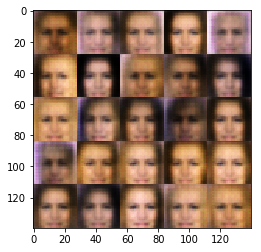

Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 3.7100
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 4.0191
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 3.4925
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 3.0486
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 3.8323
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 3.7758
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 4.5346
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 3.5326
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 3.1855
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 4.5386


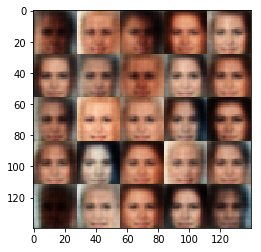

Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 5.0045
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.6036
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 3.6428
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 4.1743
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 3.0123
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 4.3540
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 4.5183
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 4.5513
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 3.8657
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 3.0698


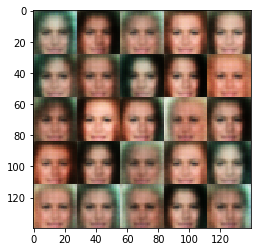

Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 3.7347
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 4.4418
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 3.2836
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 3.6724
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 4.3090
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 3.4705
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 2.9494
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 3.9053
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 3.5772
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 4.0013


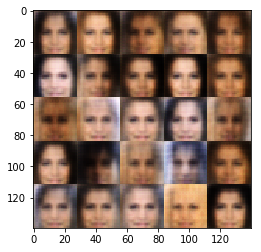

Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 3.1211
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 4.1812
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 3.2538
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 4.5350
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 4.0077
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 3.8785
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 3.3410
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 2.9663
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 4.2231
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 3.7995


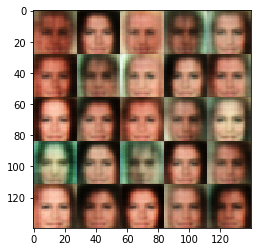

Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 4.2713
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 3.6930
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 3.5599
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 3.5057
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 2.4761
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.9636
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 3.7946
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 4.3090
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 4.1659
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.7612


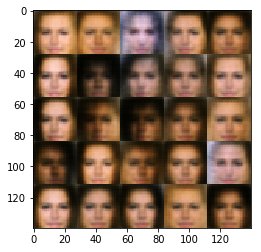

Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 4.0169
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 5.0849
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 3.5157
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 3.7837
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 3.8325
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 3.9084
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 4.2277
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 3.9132
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 4.1969
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 4.0413


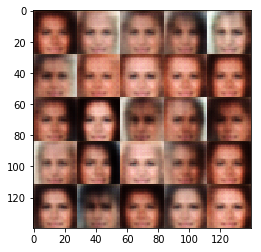

Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.9547
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 2.9856
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 3.4179
Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 2.8065
Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 3.5926
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 3.4269
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 3.2687
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 3.3334
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 3.6908
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 3.1158


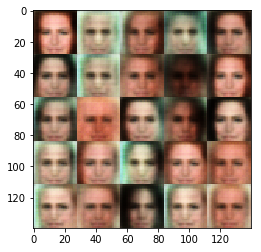

Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 3.3437
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 4.0056
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 4.2414
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 3.8585
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 4.1812
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 3.8765
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 3.1224
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 3.8503
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 4.1119
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 4.4306


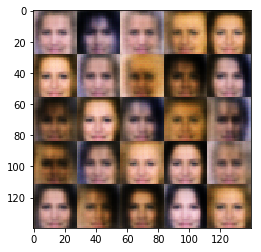

Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 4.0365
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 3.7784
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 3.2267
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.6294
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 3.4004
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 3.7554
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 4.4705
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 3.5272
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 4.4536
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 3.4386


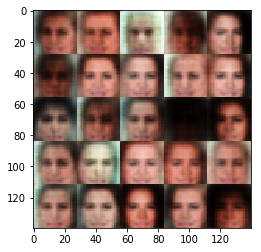

Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 4.3395
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 3.7699
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 3.7564
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 3.4410
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 3.5732
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 4.1311
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 3.4194
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 3.6214
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 4.3736
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 3.8716


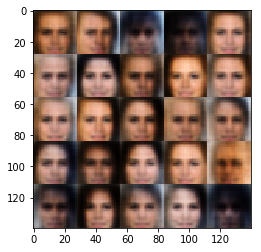

Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 3.5216
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 3.6503
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 4.4992
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 4.5171
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 4.2190
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 3.9613
Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 4.2571
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 3.5732
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 4.2182
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.9735


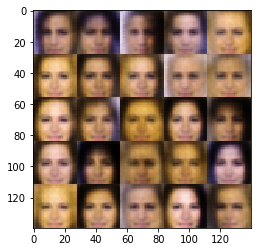

Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 4.2731
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 3.8732
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 4.0164
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 3.1564
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 3.9441
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 3.9056
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 2.8128
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 4.2342
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 3.7398
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 4.1875


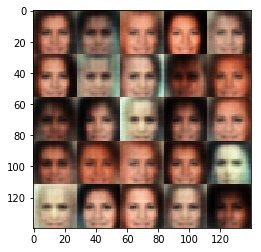

Epoch 1/1... Discriminator Loss: 0.5713... Generator Loss: 3.6642
Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 3.3778
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 4.0498
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 4.1234
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.7400
Epoch 1/1... Discriminator Loss: 0.4988... Generator Loss: 4.5394
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 4.0725
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 4.1142
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 3.6612
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 3.7692


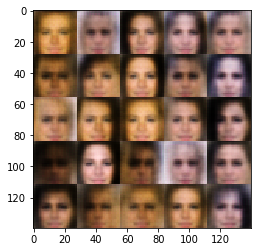

Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 4.4525
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 4.2963
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 3.2072
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 3.8736
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 4.1957
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 4.3552
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 4.3166
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 3.9450
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 3.5334
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 4.0382


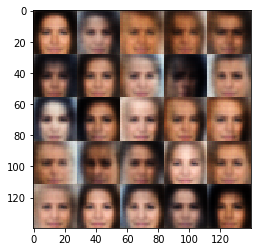

Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 3.5892
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 3.4772
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 3.3412
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 2.8398
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 4.2118
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 3.8986
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 3.5742
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 4.1298
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 4.5225
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 3.6729


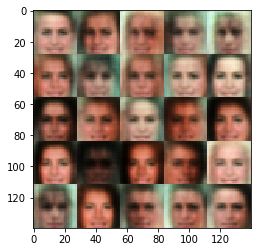

Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 4.5687
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 3.5626
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 3.2873
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 3.8618
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 3.5903
Epoch 1/1... Discriminator Loss: 0.4787... Generator Loss: 2.3065
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 3.5747
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 2.2341
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 3.9748
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 3.7949


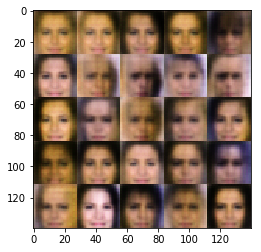

Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 3.2175
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 3.9243
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 3.9131
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 3.9139
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 4.1090
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 3.8923
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 3.3249
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 3.2471
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 3.9460
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 4.0015


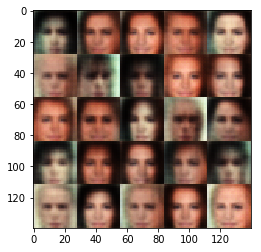

Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 4.4341
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 3.4772
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 4.2543


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.